In [2]:
# Importing packages
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python

import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trig etc.
import random
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

import itertools
from itertools import combinations

# Setting directory
os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_test") # set the working directory

In [3]:
# Importing data
data_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/CostaRica_Chemistry_20200518.csv'
data_2_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/lia_Q.csv' # DS Q
data_3_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/UpQDataSlam.csv'# US Q
data_4_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/down_q_measured.csv'# DS Q Measured
data_5_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/up_q_measured.csv'# US Q Measured
data_6_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/DownstreamMiller.csv' # Rain
data_7_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/Ratios/Ratios.csv' # US/DS ratios

# Read data from url as pandas dataframe
df = pd.read_csv(data_url)
df2 = pd.read_csv(data_2_url)
df3 = pd.read_csv(data_3_url)
df4 = pd.read_csv(data_4_url)
df5 = pd.read_csv(data_5_url)
df6 = pd.read_csv(data_6_url)
df7 = pd.read_csv(data_7_url)

# Making date columns datetime friendly (in case I wanted to index later)
df['SamplingDate'] = pd.to_datetime(df['SamplingDate'])
df['Chemetrics_Acidified_Date'] = pd.to_datetime(df['Chemetrics_Acidified_Date'])
df2['Date'] = pd.to_datetime(df2['Date'])
df3['Date'] = pd.to_datetime(df3['Date'])
df4['Date'] = pd.to_datetime(df4['Date'])
df5['Date'] = pd.to_datetime(df5['Date'])
df6['Date'] = pd.to_datetime(df6['Date'])

# Filtering endmembers
df_rain = df[df['Site'] == "Rain"].reset_index(drop=True) # Endmember 1 = Rain
df_soil = df[df['Site'] == "Soil"].reset_index(drop=True) # Endmember 2 = Soil
df_spring = df[df['Site'] == "Spring"].reset_index(drop=True) # Endmember 3a = Spring
df_us = df[(df['Site'] == "Upstream") & (df['SamplingDate'] < '2019')].reset_index(drop=True) # Endmember 3b = Upstream, not including 2019

# Filtering mixing batches
df_ds = df[(df['Site'] == "Downstream") & (df['SamplingDate'] < '2019')] # Mixing batch a, not including 2019
df_ds = df_ds[~df_ds['ID'].str.contains("Howler")] # Only want the DS samples
df_ds = df_ds[~df_ds['ID'].str.contains("DS9Bot")].reset_index(drop=True) # Filtering out DS9Bot (duplicate)
df_stream = df[(df['Source'] == "Stream") & (df['SamplingDate'] < '2019')].reset_index() # Mixing batch b, not including 2019

# Summary statistics:
df_summary = df.groupby("Site").describe()

# For this analysis, I'm dropping the US samples that are missing 
# from the DS samples (because the ISCO was not installed correctly):
# Samples 4 - 8
df_us = df_us.drop(df_us.index[3:8]).reset_index(drop=True)
# df_us = df_us.drop(df_us.index[4]).reset_index(drop=True) # Dropping sample 10
# df_ds = df_ds.drop(df_ds.index[4]).reset_index(drop=True) # Dropping sample 10

In [4]:
# Running mean function
def running_mean(in_array,window):
    import numpy as np
    w = int(np.floor(window/2))
    mean_array = np.zeros(len(in_array),dtype=np.float64)
    i = int(w)
    while i < len(in_array)-w:
        mean_array[i] = np.mean(in_array[(i-w):(i+w+1)])
        i += 1
    window_used = int(w*2 +1)
    return(mean_array,window_used)

In [5]:
# Adding running mean to US and DS hydrograph
ds_q = df2['Q'].to_numpy() # taking discharge values
rm_ds_q = running_mean(ds_q, 5) # returns 2-D array with running mean, making first two values and last two values 0, AND returning the window used.

us_q = df3['Q'].to_numpy()
rm_us_q = running_mean(us_q, 5)

df2['MovingAverage5'] = rm_ds_q[0]  # only care about first array with moving average
df3['MovingAverage5'] = rm_us_q[0] 

df2['MovingAverage5'] = df2['MovingAverage5'].replace([0], np.nan) # replace first and last two values with NaNs
df3['MovingAverage5'] = df3['MovingAverage5'].replace([0], np.nan)

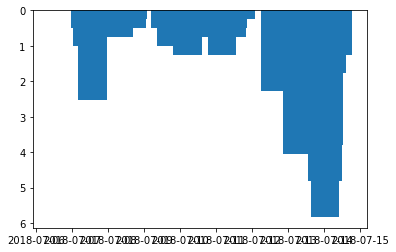

In [7]:
# Rain df6
df6_copy = df6.copy()
df6_copy['Rain'] = -1 * df6_copy['Rain']

fig, ax = plt.subplots()
ax.bar(df6_copy['Date'], df6_copy['Rain'])
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])

plt.show()

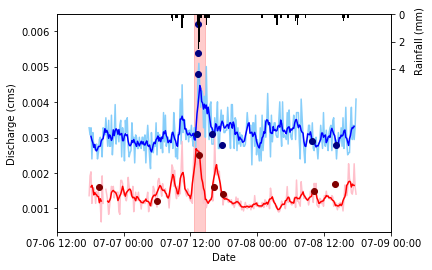

In [8]:
# Axis parameters
# xmin = pd.to_datetime('2018-07-06 00:00:00')
# xmax = pd.to_datetime('2018-07-09 00:00:00')

xmin = '2018-07-06 12:00'
xmax = '2018-07-09 00:00'

xmin = datetime.datetime.strptime(xmin, '%Y-%m-%d %H:%M')
xmax = datetime.datetime.strptime(xmax, '%Y-%m-%d %H:%M')

hours = mdates.HourLocator(interval = 12)
h_fmt = mdates.DateFormatter('%m-%d %H:%M')

# ax1.xaxis.set_major_locator(hours)
# ax1.xaxis.set_major_formatter(h_fmt)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# fig = plt.figure(figsize=[9,12], dpi=600)
# plt.subplot(325)
# plt.scatter(cell_sizes,averages, c = "black", marker='o', alpha = 0.2, edgecolors = "none")
ax1.plot(df2['Date'],df2['Q'],'-', color = "lightskyblue")
ax1.plot(df3['Date'],df3['Q'],'-', color = "pink")
ax1.plot(df2['Date'], df2['MovingAverage5'], '-', color = "blue", label = "DS")
ax1.plot(df3['Date'], df3['MovingAverage5'], '-', color = "red", label = "US")
ax1.plot(df4['Date'], df4['Q'], 'o', color = "navy")
ax1.plot(df5['Date'], df5['Q'], 'o', color = "maroon")

ax2.bar(df6_copy['Date'], df6_copy['Rain'], width=0.01, color='black')
ax2.set_ylim(-16,-0)
ax2.set_yticks([-4,-2,-0])
ticks = ax2.get_yticks()
ax2.set_yticklabels([int(abs(tick)) for tick in ticks])

ax1.axvspan(df_ds['SamplingDate'][5] - datetime.timedelta(hours=1), df_ds['SamplingDate'][5] + datetime.timedelta(hours=1), color = 'red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge (cms)')
# ax2.set_ylabel('Rainfall (mm)')

ax1.xaxis.set_major_locator(hours)
ax1.xaxis.set_major_formatter(h_fmt)
ax1.set_xlim(xmin, xmax)
ax2.xaxis.set_major_locator(hours)
ax2.xaxis.set_major_formatter(h_fmt)
ax2.set_xlim(xmin, xmax)


t = ax2.text(1.1, 0.88, 'Rainfall (mm)', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax2.transAxes)

# plt.title('Hydrograph')
# ax1.legend(loc=0, edgecolor='black')

plt.show()
# plt.ylim(8,12)
# plt.xlim(0,2000)

In [ ]:
# Nested loop: # more info: https://docs.python.org/3/library/itertools.html#itertools.combinations
# https://stackoverflow.com/questions/942543/operation-on-every-pair-of-element-in-a-list/37907649

var = ['SO4','Cl','O18','D'] # variables of interest
L = 1000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

# 1) I want to loop through every unique pair of endmembers
for pair in itertools.combinations(var, 2): # Will make unique combinations from the four variables: in total 6 pairs
    # 2) Deal with endmember pairs: Rain and Soil
    rain_1_mean = df_summary[pair[0]]['mean']['Rain']
    rain_1_stdev = df_summary[pair[0]]['std']['Rain']
    rain_2_mean = df_summary[pair[1]]['mean']['Rain']
    rain_2_stdev = df_summary[pair[1]]['std']['Rain']
    soil_1_mean = df_summary[pair[0]]['mean']['Soil']
    soil_1_stdev = df_summary[pair[0]]['std']['Soil']
    soil_2_mean = df_summary[pair[1]]['mean']['Soil']
    soil_2_stdev = df_summary[pair[1]]['std']['Soil']
    # 3) Apply normal distribution to draw L realizations for each variable and storing them in ndarrays
    rain_1 = np.random.normal(rain_1_mean, rain_1_stdev, size = L)
    rain_2 = np.random.normal(rain_2_mean, rain_2_stdev, size = L)
    soil_1 = np.random.normal(soil_1_mean, soil_1_stdev, size = L)
    soil_2 = np.random.normal(soil_2_mean, soil_2_stdev, size = L)
    # 4) Loop through each sample
    for x in range(0, len(df_ds)): # Should be DS1 - DS26, minus the ones taken out earlier
        sample = df_ds['ID'][x] # saving sample name for graphs (i.e. 'DS1')
        up_1 = np.repeat((df_us[pair[0]][x]), L) # Making repeated arrays for up and down samples
        up_2 = np.repeat((df_us[pair[1]][x]), L)
        down_1 = np.repeat((df_ds[pair[0]][x]), L)
        down_2 = np.repeat((df_ds[pair[1]][x]), L)
        results = [] # Making an empty array to hold appended results of solved linear equations in next code block
        # 5) Set up linear equations to solve for endmember fractions
        for i in range(0, L):
            a = np.array([[up_1[i], soil_1[i], rain_1[i]], [up_2[i], soil_2[i], rain_2[i]], [ones[i], ones[i], ones[i]]])
            b = np.array([down_1[i], down_2[i], ones[i]])
            results.append(np.linalg.solve(a,b)) # this function will solve for a,b
        up_f = []
        soil_f = []
        rain_f = []
        # 6) Take each endmember's fraction and append it to a numpy array
        for k in range(0,L):
            up_f.append(results[k][0])
            soil_f.append(results[k][1])
            rain_f.append(results[k][2])
        # 7) Subplots (# of rows, # of columns, unique position)
        plt.subplot(311)
        GSLIB.hist_st(up_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Up Fraction",title="Up Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplot(312)
        GSLIB.hist_st(soil_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Soil Fraction",title="Soil Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplot(313)
        GSLIB.hist_st(rain_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Rain Fraction",title="Rain Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.8)
        plt.savefig("Graph" + str(sample) + str(pair[0]) + str(pair[1]) + ".png", bbox_inches = 'tight') # MUST have bbox_inches
        plt.clf()   # closes figure so you can loop to next sample

In [96]:
var = ['SO4','Cl','O18','D'] # variables of interest
L = 1000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

# 1) I want to loop through every unique pair of endmembers
for pair in itertools.combinations(var, 2): # Will make unique combinations from the four variables: in total 6 pairs
    # 2) Deal with endmember pairs: Rain and Soil
    rain_1_mean = df_summary[pair[0]]['mean']['Rain']
    rain_1_stdev = df_summary[pair[0]]['std']['Rain']
    rain_2_mean = df_summary[pair[1]]['mean']['Rain']
    rain_2_stdev = df_summary[pair[1]]['std']['Rain']
    soil_1_mean = df_summary[pair[0]]['mean']['Soil']
    soil_1_stdev = df_summary[pair[0]]['std']['Soil']
    soil_2_mean = df_summary[pair[1]]['mean']['Soil']
    soil_2_stdev = df_summary[pair[1]]['std']['Soil']
    # 3) Apply normal distribution to draw L realizations for each variable and storing them in ndarrays
    rain_1 = np.random.normal(rain_1_mean, rain_1_stdev, size = L)
    rain_2 = np.random.normal(rain_2_mean, rain_2_stdev, size = L)
    soil_1 = np.random.normal(soil_1_mean, soil_1_stdev, size = L)
    soil_2 = np.random.normal(soil_2_mean, soil_2_stdev, size = L)
    # 4) Loop through each sample
    for x in range(0, len(df_ds)): # Should be DS1 - DS26, minus the ones taken out earlier
        sample = df_ds['ID'][x] # saving sample name for graphs (i.e. 'DS1')
        up_1 = np.repeat((df_us[pair[0]][x]), L) # Making repeated arrays for up and down samples
        up_2 = np.repeat((df_us[pair[1]][x]), L)
        down_1 = np.repeat((df_ds[pair[0]][x]), L)
        down_2 = np.repeat((df_ds[pair[1]][x]), L)
        results = [] # Making an empty array to hold appended results of solved linear equations in next code block
        # 5) Set up linear equations to solve for endmember fractions
        for i in range(0, L):
            a = np.array([[up_1[i], soil_1[i], rain_1[i]], [up_2[i], soil_2[i], rain_2[i]], [ones[i], ones[i], ones[i]]])
            b = np.array([down_1[i], down_2[i], ones[i]])
            results.append(np.linalg.solve(a,b)) # this function will solve for a,b
        up_f = []
        soil_f = []
        rain_f = []
        # 6) Take each endmember's fraction and append it to a numpy array
        for k in range(0,L):
            up_f.append(results[k][0])
            soil_f.append(results[k][1])
            rain_f.append(results[k][2])
        # 7) Subplots (# of rows, # of columns, unique position)
        fig = plt.figure(figsize=(10,8))
        plt.subplot(411)
        # fig, ax1 = plt.subplots()
        ax1 = fig.add_subplot(411)
        ax2 = ax1.twinx()
        ax1.plot(df2['Date'],df2['Q'],'-', color = "lightskyblue")
        ax1.plot(df3['Date'],df3['Q'],'-', color = "pink")
        ax1.plot(df2['Date'], df2['MovingAverage5'], '-', color = "blue", label = "DS")
        ax1.plot(df3['Date'], df3['MovingAverage5'], '-', color = "red", label = "US")
        ax1.plot(df4['Date'], df4['Q'], 'o', color = "navy")
        ax1.plot(df5['Date'], df5['Q'], 'o', color = "maroon")
        ax1.axvspan(df_ds['SamplingDate'][x] - datetime.timedelta(hours=1), df_ds['SamplingDate'][x] + datetime.timedelta(hours=1), color = 'red', alpha=0.2)
        ax2.bar(df6_copy['Date'], df6_copy['Rain'], width=0.01, color='black')
        ax2.set_ylim(-16,-0)
        ax2.set_yticks([-4,-2,-0])
        ticks = ax2.get_yticks()
        ax2.set_yticklabels([int(abs(tick)) for tick in ticks])
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Discharge (cms)')
        ax1.xaxis.set_major_locator(hours)
        ax1.xaxis.set_major_formatter(h_fmt)
        ax1.set_xlim(xmin, xmax)
        ax2.xaxis.set_major_locator(hours)
        ax2.xaxis.set_major_formatter(h_fmt)
        ax2.set_xlim(xmin, xmax)
        t = ax2.text(1.05, 0.88, 'Rainfall (mm)', rotation=90, 
                    verticalalignment='center', horizontalalignment='right', 
                    transform=ax2.transAxes)
        plt.title('Hydrograph: {0}'.format(sample))
        # ~~~~~~~~~~~~~~~
        plt.subplot(412)
        GSLIB.hist_st(up_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Up Fraction",title="Up Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,300)
        # ~~~~~~~~~~~~~~~
        plt.subplot(413)
        GSLIB.hist_st(soil_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Soil Fraction",title="Soil Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,300)
        # ~~~~~~~~~~~~~~~
        plt.subplot(414)
        GSLIB.hist_st(rain_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Rain Fraction",title="Rain Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,300)
        # ~~~~~~~~~~~~~~~
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.6)
        plt.savefig("Graph" + str(sample) + str(pair[0]) + str(pair[1]) + ".png", bbox_inches = 'tight') # MUST have bbox_inches
        plt.clf()   # closes figure so you can loop to next sample

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/U

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot inter

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/nump

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, th

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [13]:
# Mixing batch: US

# Changing working directory
os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_up") # set the working directory

var = ['SO4','Cl','O18','D'] # variables of interest
L = 1000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

df_us = df[(df['Site'] == "Upstream") & (df['SamplingDate'] < '2019')].reset_index(drop=True)

# 1) I want to loop through every unique pair of endmembers
for pair in itertools.combinations(var, 2): # Will make unique combinations from the four variables: in total 6 pairs
    # 2) Deal with endmember pairs: Rain and Soil
    rain_1_mean = df_summary[pair[0]]['mean']['Rain']
    rain_1_stdev = df_summary[pair[0]]['std']['Rain']
    rain_2_mean = df_summary[pair[1]]['mean']['Rain']
    rain_2_stdev = df_summary[pair[1]]['std']['Rain']
    soil_1_mean = df_summary[pair[0]]['mean']['Soil']
    soil_1_stdev = df_summary[pair[0]]['std']['Soil']
    soil_2_mean = df_summary[pair[1]]['mean']['Soil']
    soil_2_stdev = df_summary[pair[1]]['std']['Soil']
    spring_1_mean = df_summary[pair[0]]['mean']['Spring']
    spring_1_stdev = df_summary[pair[0]]['std']['Spring']
    spring_2_mean = df_summary[pair[1]]['mean']['Spring']
    spring_2_stdev = df_summary[pair[1]]['std']['Spring']
    # 3) Apply normal distribution to draw L realizations for each variable and storing them in ndarrays
    rain_1 = np.random.normal(rain_1_mean, rain_1_stdev, size = L)
    rain_2 = np.random.normal(rain_2_mean, rain_2_stdev, size = L)
    soil_1 = np.random.normal(soil_1_mean, soil_1_stdev, size = L)
    soil_2 = np.random.normal(soil_2_mean, soil_2_stdev, size = L)
    spring_1 = np.random.normal(spring_1_mean, spring_1_stdev, size = L)
    spring_2 = np.random.normal(spring_2_mean, spring_2_stdev, size = L)
    # 4) Loop through each sample
    for x in range(0, len(df_us)): # Should be US1 - US26, minus the ones taken out earlier
        sample = df_us['ID'][x] # saving sample name for graphs (i.e. 'DS1')
        up_1 = np.repeat((df_us[pair[0]][x]), L) # Making repeated arrays for up and down samples
        up_2 = np.repeat((df_us[pair[1]][x]), L)
        results = [] # Making an empty array to hold appended results of solved linear equations in next code block
        # 5) Set up linear equations to solve for endmember fractions
        for i in range(0, L):
            a = np.array([[spring_1[i], soil_1[i], rain_1[i]], [spring_2[i], soil_2[i], rain_2[i]], [ones[i], ones[i], ones[i]]])
            b = np.array([up_1[i], up_2[i], ones[i]])
            results.append(np.linalg.solve(a,b)) # this function will solve for a,b
        spring_f = []
        soil_f = []
        rain_f = []
        # 6) Take each endmember's fraction and append it to a numpy array
        for k in range(0,L):
            spring_f.append(results[k][0])
            soil_f.append(results[k][1])
            rain_f.append(results[k][2])
        # 7) Subplots (# of rows, # of columns, unique position)
        fig = plt.figure(figsize=(10,8))
        plt.subplot(411)
        # fig, ax1 = plt.subplots()
        ax1 = fig.add_subplot(411)
        ax2 = ax1.twinx()
        ax1.plot(df2['Date'],df2['Q'],'-', color = "lightskyblue")
        ax1.plot(df3['Date'],df3['Q'],'-', color = "pink")
        ax1.plot(df2['Date'], df2['MovingAverage5'], '-', color = "blue", label = "DS")
        ax1.plot(df3['Date'], df3['MovingAverage5'], '-', color = "red", label = "US")
        ax1.plot(df4['Date'], df4['Q'], 'o', color = "navy")
        ax1.plot(df5['Date'], df5['Q'], 'o', color = "maroon")
        ax1.axvspan(df_us['SamplingDate'][x] - datetime.timedelta(hours=1), df_us['SamplingDate'][x] + datetime.timedelta(hours=1), color = 'red', alpha=0.2)
        ax2.bar(df6_copy['Date'], df6_copy['Rain'], width=0.01, color='black')
        ax2.set_ylim(-16,-0)
        ax2.set_yticks([-4,-2,-0])
        ticks = ax2.get_yticks()
        ax2.set_yticklabels([int(abs(tick)) for tick in ticks])
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Discharge (cms)')
        ax1.xaxis.set_major_locator(hours)
        ax1.xaxis.set_major_formatter(h_fmt)
        ax1.set_xlim(xmin, xmax)
        ax2.xaxis.set_major_locator(hours)
        ax2.xaxis.set_major_formatter(h_fmt)
        ax2.set_xlim(xmin, xmax)
        t = ax2.text(1.05, 0.88, 'Rainfall (mm)', rotation=90, 
                    verticalalignment='center', horizontalalignment='right', 
                    transform=ax2.transAxes)
        plt.title('Hydrograph: {0}'.format(sample))
        # ~~~~~~~~~~~~~~~
        plt.subplot(412)
        GSLIB.hist_st(spring_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Spring Fraction",title="Spring Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,300)
        # ~~~~~~~~~~~~~~~
        plt.subplot(413)
        GSLIB.hist_st(soil_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Soil Fraction",title="Soil Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,300)
        # ~~~~~~~~~~~~~~~
        plt.subplot(414)
        GSLIB.hist_st(rain_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Rain Fraction",title="Rain Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,300)
        # ~~~~~~~~~~~~~~~
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.6)
        plt.savefig("Graph" + str(sample) + str(pair[0]) + str(pair[1]) + ".png", bbox_inches = 'tight') # MUST have bbox_inches
        plt.clf()   # closes figure so you can loop to next sample

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [15]:
# Mixing batch: US

# Changing working directory
os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_up_2") # set the working directory

var = ['SO4','Cl','O18','D'] # variables of interest
L = 1000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

df_us = df[(df['Site'] == "Upstream") & (df['SamplingDate'] < '2019')].reset_index(drop=True)

# 1) I want to loop through every unique pair of endmembers
for pair in itertools.combinations(var, 2): # Will make unique combinations from the four variables: in total 6 pairs
    # 2) Deal with endmember pairs: Rain and Soil
    rain_1_mean = df_summary[pair[0]]['mean']['Rain']
    rain_1_stdev = df_summary[pair[0]]['std']['Rain']
    rain_2_mean = df_summary[pair[1]]['mean']['Rain']
    rain_2_stdev = df_summary[pair[1]]['std']['Rain']
    soil_1_mean = df_summary[pair[0]]['mean']['Soil']
    soil_1_stdev = df_summary[pair[0]]['std']['Soil']
    soil_2_mean = df_summary[pair[1]]['mean']['Soil']
    soil_2_stdev = df_summary[pair[1]]['std']['Soil']
    spring_1_mean = df_summary[pair[0]]['mean']['Spring']
    spring_1_stdev = df_summary[pair[0]]['std']['Spring']
    spring_2_mean = df_summary[pair[1]]['mean']['Spring']
    spring_2_stdev = df_summary[pair[1]]['std']['Spring']
    # 3) Apply normal distribution to draw L realizations for each variable and storing them in ndarrays
    rain_1 = np.random.normal(rain_1_mean, rain_1_stdev, size = L)
    rain_2 = np.random.normal(rain_2_mean, rain_2_stdev, size = L)
    soil_1 = np.random.normal(soil_1_mean, soil_1_stdev, size = L)
    soil_2 = np.random.normal(soil_2_mean, soil_2_stdev, size = L)
    spring_1 = np.random.normal(spring_1_mean, spring_1_stdev, size = L)
    spring_2 = np.random.normal(spring_2_mean, spring_2_stdev, size = L)
    # 4) Loop through each sample
    for x in range(0, len(df_us)): # Should be US1 - US26, minus the ones taken out earlier
        sample = df_us['ID'][x] # saving sample name for graphs (i.e. 'DS1')
        up_1 = np.repeat((df_us[pair[0]][x]), L) # Making repeated arrays for up and down samples
        up_2 = np.repeat((df_us[pair[1]][x]), L)
        results = [] # Making an empty array to hold appended results of solved linear equations in next code block
        # 5) Set up linear equations to solve for endmember fractions
        for i in range(0, L):
            a = np.array([[spring_1[i], soil_1[i], rain_1[i]], [spring_2[i], soil_2[i], rain_2[i]], [ones[i], ones[i], ones[i]]])
            b = np.array([up_1[i], up_2[i], ones[i]])
            results.append(np.linalg.solve(a,b)) # this function will solve for a,b
        spring_f = []
        soil_f = []
        rain_f = []
        # 6) Take each endmember's fraction and append it to a numpy array
        for k in range(0,L):
            spring_f.append(results[k][0])
            soil_f.append(results[k][1])
            rain_f.append(results[k][2])
        # 7) Filter non-realistic rows, find mode (maximum in this case), standard deviation?
        df_results = results.copy()
        # 7) Subplots (# of rows, # of columns, unique position)
        fig = plt.figure(figsize=(10,8))
        plt.subplot(411)
        # fig, ax1 = plt.subplots()
        ax1 = fig.add_subplot(411)
        ax2 = ax1.twinx()
        ax1.plot(df2['Date'],df2['Q'],'-', color = "lightskyblue")
        ax1.plot(df3['Date'],df3['Q'],'-', color = "pink")
        ax1.plot(df2['Date'], df2['MovingAverage5'], '-', color = "blue", label = "DS")
        ax1.plot(df3['Date'], df3['MovingAverage5'], '-', color = "red", label = "US")
        ax1.plot(df4['Date'], df4['Q'], 'o', color = "navy")
        ax1.plot(df5['Date'], df5['Q'], 'o', color = "maroon")
        ax1.axvspan(df_us['SamplingDate'][x] - datetime.timedelta(hours=1), df_us['SamplingDate'][x] + datetime.timedelta(hours=1), color = 'red', alpha=0.2)
        ax2.bar(df6_copy['Date'], df6_copy['Rain'], width=0.01, color='black')
        ax2.set_ylim(-16,-0)
        ax2.set_yticks([-4,-2,-0])
        ticks = ax2.get_yticks()
        ax2.set_yticklabels([int(abs(tick)) for tick in ticks])
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Discharge (cms)')
        ax1.xaxis.set_major_locator(hours)
        ax1.xaxis.set_major_formatter(h_fmt)
        ax1.set_xlim(xmin, xmax)
        ax2.xaxis.set_major_locator(hours)
        ax2.xaxis.set_major_formatter(h_fmt)
        ax2.set_xlim(xmin, xmax)
        t = ax2.text(1.05, 0.88, 'Rainfall (mm)', rotation=90, 
                    verticalalignment='center', horizontalalignment='right', 
                    transform=ax2.transAxes)
        plt.title('Hydrograph: {0}'.format(sample))
        # ~~~~~~~~~~~~~~~
        plt.subplot(412)
        GSLIB.hist_st(spring_f,0,1,log=False,cumul=False,bins=50,weights=None,xlabel="Spring Fraction",title="Spring Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,100)
        # ~~~~~~~~~~~~~~~
        plt.subplot(413)
        GSLIB.hist_st(soil_f,0,1,log=False,cumul=False,bins=50,weights=None,xlabel="Soil Fraction",title="Soil Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,100)
        # ~~~~~~~~~~~~~~~
        plt.subplot(414)
        GSLIB.hist_st(rain_f,0,1,log=False,cumul=False,bins=50,weights=None,xlabel="Rain Fraction",title="Rain Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,100)
        # ~~~~~~~~~~~~~~~
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.6)
        plt.savefig("Graph" + str(sample) + str(pair[0]) + str(pair[1]) + ".png", bbox_inches = 'tight') # MUST have bbox_inches
        plt.clf()   # closes figure so you can loop to next sample

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [ ]:
# Mixing batch: US: Find mode

# Changing working directory
os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_up_2") # set the working directory

var = ['SO4','Cl','O18','D'] # variables of interest
L = 1000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

df_us = df[(df['Site'] == "Upstream") & (df['SamplingDate'] < '2019')].reset_index(drop=True)

# 1) I want to loop through every unique pair of endmembers
for pair in itertools.combinations(var, 2): # Will make unique combinations from the four variables: in total 6 pairs
    # 2) Deal with endmember pairs: Rain and Soil
    rain_1_mean = df_summary[pair[0]]['mean']['Rain']
    rain_1_stdev = df_summary[pair[0]]['std']['Rain']
    rain_2_mean = df_summary[pair[1]]['mean']['Rain']
    rain_2_stdev = df_summary[pair[1]]['std']['Rain']
    soil_1_mean = df_summary[pair[0]]['mean']['Soil']
    soil_1_stdev = df_summary[pair[0]]['std']['Soil']
    soil_2_mean = df_summary[pair[1]]['mean']['Soil']
    soil_2_stdev = df_summary[pair[1]]['std']['Soil']
    spring_1_mean = df_summary[pair[0]]['mean']['Spring']
    spring_1_stdev = df_summary[pair[0]]['std']['Spring']
    spring_2_mean = df_summary[pair[1]]['mean']['Spring']
    spring_2_stdev = df_summary[pair[1]]['std']['Spring']
    # 3) Apply normal distribution to draw L realizations for each variable and storing them in ndarrays
    rain_1 = np.random.normal(rain_1_mean, rain_1_stdev, size = L)
    rain_2 = np.random.normal(rain_2_mean, rain_2_stdev, size = L)
    soil_1 = np.random.normal(soil_1_mean, soil_1_stdev, size = L)
    soil_2 = np.random.normal(soil_2_mean, soil_2_stdev, size = L)
    spring_1 = np.random.normal(spring_1_mean, spring_1_stdev, size = L)
    spring_2 = np.random.normal(spring_2_mean, spring_2_stdev, size = L)
    # 4) Loop through each sample
    for x in range(0, len(df_us)): # Should be US1 - US26, minus the ones taken out earlier
        sample = df_us['ID'][x] # saving sample name for graphs (i.e. 'DS1')
        up_1 = np.repeat((df_us[pair[0]][x]), L) # Making repeated arrays for up and down samples
        up_2 = np.repeat((df_us[pair[1]][x]), L)
        results = [] # Making an empty array to hold appended results of solved linear equations in next code block
        # 5) Set up linear equations to solve for endmember fractions
        for i in range(0, L):
            a = np.array([[spring_1[i], soil_1[i], rain_1[i]], [spring_2[i], soil_2[i], rain_2[i]], [ones[i], ones[i], ones[i]]])
            b = np.array([up_1[i], up_2[i], ones[i]])
            results.append(np.linalg.solve(a,b)) # this function will solve for a,b
        spring_f = []
        soil_f = []
        rain_f = []
        # 6) Take each endmember's fraction and append it to a numpy array
        for k in range(0,L):
            spring_f.append(results[k][0])
            soil_f.append(results[k][1])
            rain_f.append(results[k][2])
        # 7) Filter non-realistic rows, find mode (maximum in this case), standard deviation?
        df_results = results.copy()
        indexNames = df_results[ (df_results[0] > 1) | (df_results[0] < 0) | (df_results[1] > 1) | (df_results[2] < 0) | (df_results[2] < 0) ].index
        df_results.drop(indexNames , inplace=True)

In [17]:
# Mixing batch: DS

# Changing working directory
os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_down_2") # set the working directory

var = ['SO4','Cl','O18','D'] # variables of interest
L = 1000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

# 1) I want to loop through every unique pair of endmembers
for pair in itertools.combinations(var, 2): # Will make unique combinations from the four variables: in total 6 pairs
    # 2) Deal with endmember pairs: Rain and Soil
    rain_1_mean = df_summary[pair[0]]['mean']['Rain']
    rain_1_stdev = df_summary[pair[0]]['std']['Rain']
    rain_2_mean = df_summary[pair[1]]['mean']['Rain']
    rain_2_stdev = df_summary[pair[1]]['std']['Rain']
    soil_1_mean = df_summary[pair[0]]['mean']['Soil']
    soil_1_stdev = df_summary[pair[0]]['std']['Soil']
    soil_2_mean = df_summary[pair[1]]['mean']['Soil']
    soil_2_stdev = df_summary[pair[1]]['std']['Soil']
    spring_1_mean = df_summary[pair[0]]['mean']['Spring']
    spring_1_stdev = df_summary[pair[0]]['std']['Spring']
    spring_2_mean = df_summary[pair[1]]['mean']['Spring']
    spring_2_stdev = df_summary[pair[1]]['std']['Spring']
    # 3) Apply normal distribution to draw L realizations for each variable and storing them in ndarrays
    rain_1 = np.random.normal(rain_1_mean, rain_1_stdev, size = L)
    rain_2 = np.random.normal(rain_2_mean, rain_2_stdev, size = L)
    soil_1 = np.random.normal(soil_1_mean, soil_1_stdev, size = L)
    soil_2 = np.random.normal(soil_2_mean, soil_2_stdev, size = L)
    spring_1 = np.random.normal(spring_1_mean, spring_1_stdev, size = L)
    spring_2 = np.random.normal(spring_2_mean, spring_2_stdev, size = L)
    # 4) Loop through each sample
    for x in range(0, len(df_ds)): # Should be DS1 - DS26, minus the ones taken out earlier
        sample = df_ds['ID'][x] # saving sample name for graphs (i.e. 'DS1')
        down_1 = np.repeat((df_ds[pair[0]][x]), L) # Making repeated arrays for up and down samples
        down_2 = np.repeat((df_ds[pair[1]][x]), L)
        results = [] # Making an empty array to hold appended results of solved linear equations in next code block
        # 5) Set up linear equations to solve for endmember fractions
        for i in range(0, L):
            a = np.array([[spring_1[i], soil_1[i], rain_1[i]], [spring_2[i], soil_2[i], rain_2[i]], [ones[i], ones[i], ones[i]]])
            b = np.array([down_1[i], down_2[i], ones[i]])
            results.append(np.linalg.solve(a,b)) # this function will solve for a,b
        spring_f = []
        soil_f = []
        rain_f = []
        # 6) Take each endmember's fraction and append it to a numpy array
        for k in range(0,L):
            spring_f.append(results[k][0])
            soil_f.append(results[k][1])
            rain_f.append(results[k][2])
        # 7) Subplots (# of rows, # of columns, unique position)
        fig = plt.figure(figsize=(10,8))
        plt.subplot(411)
        # fig, ax1 = plt.subplots()
        ax1 = fig.add_subplot(411)
        ax2 = ax1.twinx()
        ax1.plot(df2['Date'],df2['Q'],'-', color = "lightskyblue")
        ax1.plot(df3['Date'],df3['Q'],'-', color = "pink")
        ax1.plot(df2['Date'], df2['MovingAverage5'], '-', color = "blue", label = "DS")
        ax1.plot(df3['Date'], df3['MovingAverage5'], '-', color = "red", label = "US")
        ax1.plot(df4['Date'], df4['Q'], 'o', color = "navy")
        ax1.plot(df5['Date'], df5['Q'], 'o', color = "maroon")
        ax1.axvspan(df_us['SamplingDate'][x] - datetime.timedelta(hours=1), df_us['SamplingDate'][x] + datetime.timedelta(hours=1), color = 'red', alpha=0.2)
        ax2.bar(df6_copy['Date'], df6_copy['Rain'], width=0.01, color='black')
        ax2.set_ylim(-16,-0)
        ax2.set_yticks([-4,-2,-0])
        ticks = ax2.get_yticks()
        ax2.set_yticklabels([int(abs(tick)) for tick in ticks])
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Discharge (cms)')
        ax1.xaxis.set_major_locator(hours)
        ax1.xaxis.set_major_formatter(h_fmt)
        ax1.set_xlim(xmin, xmax)
        ax2.xaxis.set_major_locator(hours)
        ax2.xaxis.set_major_formatter(h_fmt)
        ax2.set_xlim(xmin, xmax)
        t = ax2.text(1.05, 0.88, 'Rainfall (mm)', rotation=90, 
                    verticalalignment='center', horizontalalignment='right', 
                    transform=ax2.transAxes)
        plt.title('Hydrograph: {0}'.format(sample))
        # ~~~~~~~~~~~~~~~
        plt.subplot(412)
        GSLIB.hist_st(spring_f,0,1,log=False,cumul=False,bins=50,weights=None,xlabel="Spring Fraction",title="Spring Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,100)
        # ~~~~~~~~~~~~~~~
        plt.subplot(413)
        GSLIB.hist_st(soil_f,0,1,log=False,cumul=False,bins=50,weights=None,xlabel="Soil Fraction",title="Soil Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,100)
        # ~~~~~~~~~~~~~~~
        plt.subplot(414)
        GSLIB.hist_st(rain_f,0,1,log=False,cumul=False,bins=50,weights=None,xlabel="Rain Fraction",title="Rain Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,100)
        # ~~~~~~~~~~~~~~~
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.6)
        plt.savefig("Graph" + str(sample) + str(pair[0]) + str(pair[1]) + ".png", bbox_inches = 'tight') # MUST have bbox_inches
        plt.clf()   # closes figure so you can loop to next sample

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/U

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot inter

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/nump

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, th

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [13]:
####
var = ['SO4','Cl','O18','D'] # variables of interest
L = 1000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

# masking DS2,3
ratios = df7.copy()
ratios = ratios.drop(ratios.index[1:3]).reset_index(drop=True)

df = df[df['SamplingDate'] < '2019'].reset_index(drop=True)

In [6]:
####
# Changing working directory
os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_down_20200821") # set the working directory

# masking DS2,3
ratios = df7.copy()
ratios = ratios.drop(ratios.index[1:3]).reset_index(drop=True)

df = df[df['SamplingDate'] < '2019'].reset_index(drop=True)

var = ['SO4','Cl','O18','D'] # variables of interest
L = 1000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

df_summary = df.groupby("Site").describe() # Rain (n=2), Spring (n=2), Soil is still variable

# Filtering endmembers
df_rain = df[df['Site'] == "Rain"].reset_index(drop=True) # Endmember 1 = Rain
df_soil = df[df['Site'] == "Soil"].reset_index(drop=True) # Endmember 2 = Soil
df_spring = df[df['Site'] == "Spring"].reset_index(drop=True) # Endmember 3a = Spring

# 1) I want to loop through every unique pair of endmembers
for pair in itertools.combinations(var, 2): # Will make unique combinations from the four variables: in total 6 pairs
    # 2) Deal with endmember pairs: Rain and Soil
    rain_1_mean = df_summary[pair[0]]['mean']['Rain']
    rain_1_stdev = df_summary[pair[0]]['std']['Rain']
    rain_2_mean = df_summary[pair[1]]['mean']['Rain']
    rain_2_stdev = df_summary[pair[1]]['std']['Rain']
    soil_1_mean = df_summary[pair[0]]['mean']['Soil']
    soil_1_stdev = df_summary[pair[0]]['std']['Soil']
    soil_2_mean = df_summary[pair[1]]['mean']['Soil']
    soil_2_stdev = df_summary[pair[1]]['std']['Soil']
    # 3) Apply normal distribution to draw L realizations for each variable and storing them in ndarrays
    rain_1 = np.random.normal(rain_1_mean, rain_1_stdev, size = L)
    rain_2 = np.random.normal(rain_2_mean, rain_2_stdev, size = L)
    soil_1 = np.random.normal(soil_1_mean, soil_1_stdev, size = L)
    soil_2 = np.random.normal(soil_2_mean, soil_2_stdev, size = L)
    # 4) Loop through each sample
    for x in range(0, len(df_ds)): # Should be DS1 - DS26, minus the ones taken out earlier
        sample = df_ds['ID'][x] # saving sample name for graphs (i.e. 'DS1')
        up_f_1 = np.repeat((ratios['Ratio'][x]), L) 
        up_f_2 = np.repeat((ratios['Ratio'][x]), L) # should be the same as up_f_1
        up_1 = np.repeat((df_us[pair[0]][x]), L) # Making repeated arrays for up and down samples
        up_2 = np.repeat((df_us[pair[1]][x]), L)
        down_1 = np.repeat((df_ds[pair[0]][x]), L)
        down_2 = np.repeat((df_ds[pair[1]][x]), L)
        results = [] # Making an empty array to hold appended results of solved linear equations in next code block
        # 5) Set up linear equations to solve for endmember fractions
        for i in range(0, L):
            a = np.array([[soil_1[i], rain_1[i]], [soil_2[i], rain_2[i]], [ones[i], ones[i]]])
            b = np.array([down_1[i]-(up_f_1[i]*up_1[i]), down_2[i]-(up_f_2[i]*up_2[i]), ones[i]-up_f_1])
            results.append(np.linalg.solve(a,b)) # this function will solve for a,b
        # up_f = []
        soil_f = []
        rain_f = []
        # 6) Take each endmember's fraction and append it to a numpy array
        for k in range(0,L):
            # up_f.append(results[k][0])
            soil_f.append(results[k][1])
            rain_f.append(results[k][2])
        # 7) Subplots (# of rows, # of columns, unique position)
        plt.subplot(311)
        GSLIB.hist_st(up_f_1,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Up Fraction",title="Up Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplot(312)
        GSLIB.hist_st(soil_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Soil Fraction",title="Soil Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplot(313)
        GSLIB.hist_st(rain_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Rain Fraction",title="Rain Fraction: {0} with {1} and {2}".format(sample, pair[0], pair[1]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.8)
        plt.savefig("Graph" + str(sample) + str(pair[0]) + str(pair[1]) + ".png", bbox_inches = 'tight') # MUST have bbox_inches
        plt.clf()   # closes figure so you can loop to next sample

LinAlgError: Last 2 dimensions of the array must be square

In [16]:
b

array([0.3927146700705,
       array([0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 0.51066683, 0.51066683, 0.51066683,
       0.51066683, 0.51066683, 

In [37]:
####
# Changing working directory
os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_down_20200821") # set the working directory

# masking DS2,3
ratios = df7.copy()
ratios = ratios.drop(ratios.index[1:3]).reset_index(drop=True)

df = df[df['SamplingDate'] < '2019'].reset_index(drop=True)

var = ['SO4','Cl','O18','D'] # variables of interest
L = 1000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

df_summary = df.groupby("Site").describe() # Rain (n=2), Spring (n=2), Soil is still variable

# Filtering endmembers
df_rain = df[df['Site'] == "Rain"].reset_index(drop=True) # Endmember 1 = Rain
df_soil = df[df['Site'] == "Soil"].reset_index(drop=True) # Endmember 2 = Soil
df_spring = df[df['Site'] == "Spring"].reset_index(drop=True) # Endmember 3a = Spring


to_drop = ['DS2', 'DS3', 'DS10']
df_ds = df_ds[~df_ds['ID'].isin(to_drop)].reset_index(drop=True)

# 1) I want to loop through every unique pair of endmembers
for pair in itertools.combinations(var, 2): # Will make unique combinations from the four variables: in total 6 pairs
    # 2) Deal with endmember pairs: Rain and Soil
    rain_1_mean = df_summary[pair[0]]['mean']['Rain']
    rain_1_stdev = df_summary[pair[0]]['std']['Rain']
    rain_2_mean = df_summary[pair[1]]['mean']['Rain']
    rain_2_stdev = df_summary[pair[1]]['std']['Rain']
    soil_1_mean = df_summary[pair[0]]['mean']['Soil']
    soil_1_stdev = df_summary[pair[0]]['std']['Soil']
    soil_2_mean = df_summary[pair[1]]['mean']['Soil']
    soil_2_stdev = df_summary[pair[1]]['std']['Soil']
    # 3) Apply normal distribution to draw L realizations for each variable and storing them in ndarrays
    rain_1 = np.random.normal(rain_1_mean, rain_1_stdev, size = L)
    rain_2 = np.random.normal(rain_2_mean, rain_2_stdev, size = L)
    soil_1 = np.random.normal(soil_1_mean, soil_1_stdev, size = L)
    soil_2 = np.random.normal(soil_2_mean, soil_2_stdev, size = L)
    # 4) Loop through each sample
    for x in range(0, len(df_ds)): # Should be DS1 - DS26, minus the ones taken out earlier
        sample = df_ds['ID'][x] # saving sample name for graphs (i.e. 'DS1')
        up_f_1 = np.repeat((ratios['Ratio'][x]), L) 
        up_1 = np.repeat((df_us[pair[0]][x]), L) # Making repeated arrays for up and down samples
        down_1 = np.repeat((df_ds[pair[0]][x]), L)
        results = [] # Making an empty array to hold appended results of solved linear equations in next code block
        # 5) Set up linear equations to solve for endmember fractions
        for i in range(0, L):
            a = np.array([[soil_1[i], rain_1[i]], [ones[i], ones[i]]])
            b = np.array([down_1[i]-(up_f_1[i]*up_1[i]), ones[i]-up_f_1[i]])
            results.append(np.linalg.solve(a,b)) # this function will solve for a,b
        soil_f = []
        rain_f = []
        # 6) Take each endmember's fraction and append it to a numpy array
        for k in range(0,L):
            soil_f.append(results[k][0])
            rain_f.append(results[k][1])
        # 7) Subplots (# of rows, # of columns, unique position)
        plt.subplot(311)
        GSLIB.hist_st(up_f_1,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Up Fraction",title="Up Fraction: {0} with {1}".format(sample, pair[0]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplot(312)
        GSLIB.hist_st(soil_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Soil Fraction",title="Soil Fraction: {0} with {1}".format(sample, pair[0]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplot(313)
        GSLIB.hist_st(rain_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Rain Fraction",title="Rain Fraction: {0} with {1}".format(sample, pair[0]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.8)
        plt.savefig("Graph" + str(sample) + str(pair[0]) + str(pair[1]) + ".png", bbox_inches = 'tight') # MUST have bbox_inches
        plt.clf()   # closes figure so you can loop to next sample

<Figure size 432x288 with 0 Axes>

In [41]:
####
# Changing working directory
os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_down_sp") # set the working directory

# masking DS2,3
ratios = df7.copy()
ratios = ratios.drop(ratios.index[1:3]).reset_index(drop=True)

df = df[df['SamplingDate'] < '2019'].reset_index(drop=True)

var = ['SO4','Cl','O18','D'] # variables of interest
L = 1000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

to_drop_2 = ['Well']
df = df[~df['ID'].isin(to_drop_2)].reset_index(drop=True)

df_summary = df.groupby("Site").describe() # Rain (n=2), Spring (n=2), Soil (constrained to seeps HW Trib and USLB)

# Filtering endmembers
df_rain = df[df['Site'] == "Rain"].reset_index(drop=True) # Endmember 1 = Rain
df_soil = df[df['Site'] == "Soil"].reset_index(drop=True) # Endmember 2 = Soil
df_spring = df[df['Site'] == "Spring"].reset_index(drop=True) # Endmember 3a = Spring


to_drop = ['DS2', 'DS3', 'DS10']
df_ds = df_ds[~df_ds['ID'].isin(to_drop)].reset_index(drop=True)

# 1) I want to loop through every unique pair of endmembers
for pair in itertools.combinations(var, 2): # Will make unique combinations from the four variables: in total 6 pairs
    # 2) Deal with endmember pairs: Rain and Soil
    rain_1_mean = df_summary[pair[0]]['mean']['Rain']
    rain_1_stdev = df_summary[pair[0]]['std']['Rain']
    rain_2_mean = df_summary[pair[1]]['mean']['Rain']
    rain_2_stdev = df_summary[pair[1]]['std']['Rain']
    soil_1_mean = df_summary[pair[0]]['mean']['Soil']
    soil_1_stdev = df_summary[pair[0]]['std']['Soil']
    soil_2_mean = df_summary[pair[1]]['mean']['Soil']
    soil_2_stdev = df_summary[pair[1]]['std']['Soil']
    # 3) Apply normal distribution to draw L realizations for each variable and storing them in ndarrays
    rain_1 = np.random.normal(rain_1_mean, rain_1_stdev, size = L)
    rain_2 = np.random.normal(rain_2_mean, rain_2_stdev, size = L)
    soil_1 = np.random.normal(soil_1_mean, soil_1_stdev, size = L)
    soil_2 = np.random.normal(soil_2_mean, soil_2_stdev, size = L)
    # 4) Loop through each sample
    for x in range(0, len(df_ds)): # Should be DS1 - DS26, minus the ones taken out earlier
        sample = df_ds['ID'][x] # saving sample name for graphs (i.e. 'DS1')
        up_f_1 = np.repeat((ratios['Ratio'][x]), L) 
        up_1 = np.repeat((df_us[pair[0]][x]), L) # Making repeated arrays for up and down samples
        down_1 = np.repeat((df_ds[pair[0]][x]), L)
        results = [] # Making an empty array to hold appended results of solved linear equations in next code block
        # 5) Set up linear equations to solve for endmember fractions
        for i in range(0, L):
            a = np.array([[soil_1[i], rain_1[i]], [ones[i], ones[i]]])
            b = np.array([down_1[i]-(up_f_1[i]*up_1[i]), ones[i]-up_f_1[i]])
            results.append(np.linalg.solve(a,b)) # this function will solve for a,b
        soil_f = []
        rain_f = []
        # 6) Take each endmember's fraction and append it to a numpy array
        for k in range(0,L):
            soil_f.append(results[k][0])
            rain_f.append(results[k][1])
        # 7) Subplots (# of rows, # of columns, unique position)
        plt.subplot(311)
        GSLIB.hist_st(up_f_1,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Up Fraction",title="Up Fraction: {0} with {1}".format(sample, pair[0]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplot(312)
        GSLIB.hist_st(soil_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Soil Fraction",title="Soil Fraction: {0} with {1}".format(sample, pair[0]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplot(313)
        GSLIB.hist_st(rain_f,-1,2,log=False,cumul=False,bins=50,weights=None,xlabel="Rain Fraction",title="Rain Fraction: {0} with {1}".format(sample, pair[0]))
        plt.ylim(0.0,500)
        # ~~~~~~~~~~~~~~~
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.8)
        plt.savefig("Graph" + str(sample) + str(pair[0]) + str(pair[1]) + ".png", bbox_inches = 'tight') # MUST have bbox_inches
        plt.clf()   # closes figure so you can loop to next sample

/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/wnguyen/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 432x288 with 0 Axes>

In [ ]:
# convert -delay 60 *ClD.png ClD.gif

In [40]:
df

,ID,SamplingDate,Chemetrics_Acidified_Date,Site,Source,Temp,SPCOND,pH,ORP,AlkalinityS,...,B,Sr,Sr2,Ba,K,As,Na,Mg,O18,D
0,Well 202,2018-07-01 17:00:00,2018-07-01 17:00:00,Soil,Soil,22.2,122.1,4.0,344.0,NaN,...,225.81,104.53,NaN,NaN,1.87,0.37,7.34,3.11,-6.02,-27.1
1,Well 200,2018-07-01 15:06:00,2018-07-01 15:06:00,Soil,Soil,22.4,35.0,5.3,205.0,NaN,...,52.39,17.02,NaN,NaN,0.34,0.01,2.01,0.51,-6.49,-26.9
2,Sp. Box,2018-07-02 11:23:00,2018-07-02 11:23:00,Spring,Spring,22.3,83.1,6.6,307.0,NaN,...,44.51,73.00,NaN,NaN,2.23,0.05,4.90,1.67,-5.34,-25.5
3,Howler Weir,2018-07-02 13:53:00,2018-07-02 13:53:00,Downstream,Stream,22.2,110.8,7.0,315.0,43.0,...,45.26,104.71,NaN,NaN,2.79,0.31,6.08,3.16,-6.69,-28.1
4,Howler 2,2018-07-02 13:15:00,2018-07-02 13:15:00,Downstream,Stream,22.0,115.9,5.5,350.0,14.0,...,37.78,99.93,NaN,NaN,2.55,0.30,5.29,2.80,-5.21,-25.3
5,HW Trib,2018-07-02 14:17:00,2018-07-02 14:17:00,Soil,Soil,22.6,71.9,7.0,261.0,19.0,...,42.44,79.06,NaN,NaN,2.19,0.04,5.98,1.79,-5.55,-27.1
6,Well 203,2018-07-03 09:26:00,2018-07-03 09:26:00,Soil,Soil,23.0,84.9,5.7,354.0,NaN,...,171.86,108.26,NaN,NaN,1.12,0.12,5.24,2.60,-5.44,-25.1
7,Well 205,2018-07-05 15:00:00,2018-07-05 15:00:00,Soil,Soil,22.3,108.2,6.6,208.0,NaN,...,105.20,99.21,NaN,NaN,2.14,0.17,4.71,2.50,-4.68,-26.2
8,DS1,2018-07-06 17:17:00,2018-07-06 17:17:00,Downstream,Stream,22.2,112.7,7.4,268.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.88,-22.9
9,US1,2018-07-06 17:52:00,2018-07-06 17:52:00,Upstream,Stream,22.0,113.4,6.1,307.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.85,-25.2


In [29]:
to_drop = ['DS2', 'DS3', 'DS10']
df_ds = df_ds[~df_ds['ID'].isin(to_drop)]

In [38]:
df

,ID,SamplingDate,Chemetrics_Acidified_Date,Site,Source,Temp,SPCOND,pH,ORP,AlkalinityS,...,B,Sr,Sr2,Ba,K,As,Na,Mg,O18,D
0,Well 202,2018-07-01 17:00:00,2018-07-01 17:00:00,Soil,Soil,22.2,122.1,4.0,344.0,NaN,...,225.81,104.53,NaN,NaN,1.87,0.37,7.34,3.11,-6.02,-27.1
1,Well 200,2018-07-01 15:06:00,2018-07-01 15:06:00,Soil,Soil,22.4,35.0,5.3,205.0,NaN,...,52.39,17.02,NaN,NaN,0.34,0.01,2.01,0.51,-6.49,-26.9
2,Sp. Box,2018-07-02 11:23:00,2018-07-02 11:23:00,Spring,Spring,22.3,83.1,6.6,307.0,NaN,...,44.51,73.00,NaN,NaN,2.23,0.05,4.90,1.67,-5.34,-25.5
3,Howler Weir,2018-07-02 13:53:00,2018-07-02 13:53:00,Downstream,Stream,22.2,110.8,7.0,315.0,43.0,...,45.26,104.71,NaN,NaN,2.79,0.31,6.08,3.16,-6.69,-28.1
4,Howler 2,2018-07-02 13:15:00,2018-07-02 13:15:00,Downstream,Stream,22.0,115.9,5.5,350.0,14.0,...,37.78,99.93,NaN,NaN,2.55,0.30,5.29,2.80,-5.21,-25.3
5,HW Trib,2018-07-02 14:17:00,2018-07-02 14:17:00,Soil,Soil,22.6,71.9,7.0,261.0,19.0,...,42.44,79.06,NaN,NaN,2.19,0.04,5.98,1.79,-5.55,-27.1
6,Well 203,2018-07-03 09:26:00,2018-07-03 09:26:00,Soil,Soil,23.0,84.9,5.7,354.0,NaN,...,171.86,108.26,NaN,NaN,1.12,0.12,5.24,2.60,-5.44,-25.1
7,Well 205,2018-07-05 15:00:00,2018-07-05 15:00:00,Soil,Soil,22.3,108.2,6.6,208.0,NaN,...,105.20,99.21,NaN,NaN,2.14,0.17,4.71,2.50,-4.68,-26.2
8,DS1,2018-07-06 17:17:00,2018-07-06 17:17:00,Downstream,Stream,22.2,112.7,7.4,268.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.88,-22.9
9,DS2,2018-07-06 19:30:00,2018-07-06 19:30:00,Downstream,Stream,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.28,-26.4
